## Semantic Search using Mean of Word Vectors (MWV)
### [CISI Dataset](https://www.kaggle.com/datasets/dmaso01dsta/cisi-a-dataset-for-information-retrieval)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=02c41d7282e6691fedfb04dd199e40bfd43a939c308e1959e4f8d7f68a7da3e3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import os
import pandas as pd
import collections
#Libraries for NLP
import re #for regex removal
import nltk
nltk.download('punkt') #for tokenization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords #for removing stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer #for lemmatization
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from functools import reduce #concatenate words into sentence using reduce
#Libraries for word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras_preprocessing.sequence import pad_sequences
#Libraries for cosine similarity
import numpy as np
from numpy.linalg import norm
#Libraries for loading pretrained word embeddings
import gensim.downloader as api
#Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### 1.Load Dataset Files  <a id="load_data">

In [ ]:
def load_data(path):
    import os

    #_____________ Read data from CISI.ALL file and store in dictinary ________________

    with open(os.path.join(path, 'CISI.ALL')) as f:
        lines = ""
        for l in f.readlines():
            # add new line char for lines starting with (.) and add space for other lines
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        #split a string into list based on newline(\n) separator.
        lines = lines.lstrip("\n").split("\n")

    # Put each DOCUMENT into a dictionary doc_set
    doc_set = {}
    doc_id = ""
    doc_text = ""

    for l in lines:
        if l.startswith(".I"):
            doc_id = l.split(" ")[1].strip() # l='.I 1' -> doc_id = 1
        elif l.startswith(".X"):
            # indicate document ending
            doc_set[doc_id] = doc_text.lstrip(" ")
            doc_id = ""
            doc_text = ""
        else:
            # ignore first 3 characters of a line. l='.T 18 Editions..' -> doc_text = 19 Editions..
            doc_text += l.strip()[3:] + " "

    print(f"Number of documents = {len(doc_set)}")
    print(doc_set["1"]) # note that the dictionary indexes are strings, not numbers.


    #_____________ Read data from CISI.QRY file and store in dictinary ________________

    with open(os.path.join(path, 'CISI.QRY')) as f:
        lines = ""
        for l in f.readlines():
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        lines = lines.lstrip("\n").split("\n")

    # Put each QUERY into a dictionary doc_set.
    qry_set = {}
    qry_id = ""
    for l in lines:
        if l.startswith(".I"):
            qry_id = l.split(" ")[1].strip() # l='.I 1' -> doc_id = 1
        elif l.startswith(".W"):
            # ignore first 3 characters of a line. l='.T 18 Editions..' -> doc_text = 19 Editions..
            qry_set[qry_id] = l.strip()[3:]
            qry_id = ""

    print(f"\n\nNumber of queries = {len(qry_set)}")
    print(qry_set["1"]) # note that the dictionary indexes are strings, not numbers.


    #_____________ Read data from CISI.REL file and store in dictinary ________________

    rel_set = {}
    with open(os.path.join(path, 'CISI.REL')) as f:
        for l in f.readlines():
            qry_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0] #split("\t")[0] -> '1     28'
            doc_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1] #                 [0]   [-1]

            if qry_id in rel_set:
                rel_set[qry_id].append(doc_id)
            else:
                rel_set[qry_id] = []
                rel_set[qry_id].append(doc_id)

    print(f"\n\nNumber of mappings = {len(rel_set)}")
    print(rel_set["1"]) # note that the dictionary indexes are strings, not numbers.

    return doc_set, qry_set, rel_set

In [ ]:
# returns dictionary with key->doc_id/query_id and value->data
doc_set, qry_set, rel_set = load_data('/content/drive/MyDrive/Internship Material/Wolters Kluwer/data/Information Retrieval')

Number of documents = 1460
18 Editions of the Dewey Decimal Classifications Comaromi, J.P. The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad. 


Number of queries = 112
What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?


Number of mappings = 76
['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '1

#### 1.1 Length of documents and Queries

In [ ]:
def get_length(doc_set, qry_set):
    # Length of documents
    min_d = 9999
    max_d = 0
    for i in doc_set:
        min_d = min(min_d, len(doc_set[i]))
        max_d = max(max_d, len(doc_set[i]))
    print(f"Doc length\n no. of characters min: {min_d}, max: {max_d}")

    # Length of queries
    min_q = 9999
    max_q = 0
    for i in qry_set:
        min_d = min(min_q, len(qry_set[i]))
        max_d = max(max_q, len(qry_set[i]))
    print(f"\nQuery length\n no. of characters min: {min_d}, max: {max_d}")

In [ ]:
get_length(doc_set, qry_set)

Doc length
 no. of characters min: 99, max: 3903

Query length
 no. of characters min: 432, max: 432


#### 1.2.Download Pretrained embeddings

In [ ]:
#Download pre-trained Twitter GloVe embeddings
import wget
wget.download('https://nlp.stanford.edu/data/glove.6B.zip')

'glove.6B.zip'

In [ ]:
import zipfile
with zipfile.ZipFile("glove.6B.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Internship Material/Wolters Kluwer")

In [ ]:
#Download fastText Pre-trained word vectors
import wget
wget.download('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip')

'wiki-news-300d-1M.vec.zip'

In [ ]:
import zipfile
with zipfile.ZipFile("wiki-news-300d-1M.vec.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Internship Material/Wolters Kluwer")

#### 1.3.Download or Load Pretrained embeddings using Gensim api

In [ ]:
import gensim.downloader as api

data = api.info()  # return dict with info about available models/datasets
for (key, val) in data.items():
    print(f"\n{key}:")
    for (name, property) in val.items():
        print(f"{name}")


corpora:
semeval-2016-2017-task3-subtaskBC
semeval-2016-2017-task3-subtaskA-unannotated
patent-2017
quora-duplicate-questions
wiki-english-20171001
text8
fake-news
20-newsgroups
__testing_matrix-synopsis
__testing_multipart-matrix-synopsis

models:
fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
# Download model and get its path
glove_model_path = api.load("glove-wiki-gigaword-100", return_path=True)
print(glove_model_path)
# unzip and extract the file

In [ ]:
# Download model and load it in memory
glove_model = api.load("glove-wiki-gigaword-100")
glove_model.most_similar("cat")

### 2.Data Wrangling <a id="preprocess_data">

#### 2.1.Train word2vec word embeddings

##### 2.1.1.Preprocess Documents and Queries Data

In [ ]:
#Customize stopwords list
for i in ["not", "no"]:
    stop_words.remove(i)
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(data_dict):
    docs = {}

    for key in data_dict:

        line = data_dict[key]
        #1. Removing upper brackets to keep words like [user\'s]
        line = line.replace("\'", "")

        #2. Removing symbols and numbers
        line = re.sub(r"[^a-zA-Z]+", ' ', line).strip()

        #3. Convert string to tokens, lowercase it & remove stop words
        tokens = word_tokenize(line)  #to convert a string to tokens
        tokens = [w.lower() for w in tokens if len(w)>1] #convert to lowercase
        tokens = [w for w in tokens if w not in stop_words] #remove stop words

        #4. Convert word to its base form
        lemmatized_tokens = []
        for word, tag in pos_tag(tokens):
            if tag.startswith('NN'):
                pos = 'n'
            elif tag.startswith('VB'):
                pos = 'v'
            else:
                pos = 'a'
            lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))

        docs[key] = lemmatized_tokens

    return docs

In [ ]:
# preprocessing documents
preprocessed_doc_dict = preprocess(doc_set)
print(preprocessed_doc_dict['1'])

['edition', 'dewey', 'decimal', 'classification', 'comaromi', 'present', 'study', 'history', 'dewey', 'decimal', 'classification', 'first', 'edition', 'ddc', 'publish', 'eighteenth', 'edition', 'future', 'edition', 'continue', 'appear', 'need', 'spite', 'ddc', 'long', 'healthy', 'life', 'however', 'full', 'story', 'never', 'tell', 'biography', 'dewey', 'briefly', 'describe', 'system', 'first', 'attempt', 'provide', 'detailed', 'history', 'work', 'spur', 'growth', 'librarianship', 'country', 'abroad']


In [ ]:
# preprocessing queries
preprocessed_qry_dict = preprocess(qry_set)
print(preprocessed_qry_dict['1'])

['problem', 'concern', 'make', 'descriptive', 'title', 'difficulty', 'involve', 'automatically', 'retrieve', 'article', 'approximate', 'title', 'usual', 'relevance', 'content', 'article', 'title']


##### 2.1.2.Create word embedding using Gensim Word2Vec model

In [ ]:
w2v_model = Word2Vec(sentences = preprocessed_doc_dict.values(),
                     size = 100,
                     window = 5,
                     min_count = 2,
                     workers = 4,
                     sg = 1)

In [ ]:
 w2v_model.wv['problem']

array([ 0.05787969,  0.11180916,  0.18571176, -0.1349912 , -0.02288479,
        0.35009602,  0.03563846, -0.03727943,  0.1845926 , -0.04487828,
       -0.19501612, -0.2537288 ,  0.21835636,  0.24696572, -0.03822354,
        0.1743753 , -0.02744512,  0.2778702 , -0.14017916,  0.211091  ,
       -0.2808572 , -0.2392902 ,  0.01794457,  0.24286883,  0.2952813 ,
       -0.02096155,  0.06977712, -0.01718239, -0.14312986,  0.11094255,
       -0.20992641, -0.04374977, -0.17760082,  0.04752033, -0.02692778,
       -0.03591209,  0.0518254 ,  0.09046426, -0.19616544, -0.15752171,
       -0.26804173,  0.03612823,  0.3512453 , -0.03283618, -0.3041192 ,
        0.36748588,  0.02929458,  0.20433109,  0.24936445,  0.12686683,
        0.11139556, -0.01818663, -0.3620176 ,  0.0707208 ,  0.00673978,
        0.07032125,  0.13392933,  0.1195476 ,  0.21978252,  0.40023398,
       -0.25376904, -0.09733296,  0.18785635,  0.2592108 ,  0.20730068,
       -0.19063772, -0.4765889 , -0.0919236 ,  0.08002228,  0.12

In [ ]:
w2v_model.wv.most_similar('service')

[('awareness', 0.9443937540054321),
 ('center', 0.9278586506843567),
 ('current', 0.9131313562393188),
 ('survey', 0.9031283855438232),
 ('selective', 0.8987606763839722),
 ('sdi', 0.8956398963928223),
 ('available', 0.8952839374542236),
 ('institute', 0.895150899887085),
 ('provide', 0.8804277181625366),
 ('national', 0.8801548480987549)]

In [ ]:
w2v_model.wv.most_similar('problem')

[('solution', 0.9755209684371948),
 ('consider', 0.9655518531799316),
 ('general', 0.9615664482116699),
 ('practical', 0.9598991870880127),
 ('nature', 0.959527850151062),
 ('solve', 0.9570852518081665),
 ('decision', 0.9541671276092529),
 ('framework', 0.9463167190551758),
 ('attempt', 0.9439836740493774),
 ('organizational', 0.9424759149551392)]

##### 2.1.3.Storing embeddings  as text file

In [ ]:
#Store word embeddings
w2v_model.wv.save_word2vec_format('docs_embedding_word2vec.txt' ,binary=False)

##### 2.1.4.Load word Embeddings <a id='2.4'>

In [ ]:
def load_embeddings(filepath):
  pretrained_embeddings_dict = {}
  with open(filepath) as f:
      for line in f:
        values = line.split()
        if(len(values)==2): #To skip first value
            continue
        word = values[0]
        coefs = np.asarray(values[1:])
        pretrained_embeddings_dict[word] = coefs.astype(np.float64)
  return pretrained_embeddings_dict

In [ ]:
#Load words and embeddings
embeddings_dict = {}
f = open(os.path.join(os.getcwd(), 'docs_embedding_word2vec.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    if(len(values)==2): #To skip first value
        continue
    word = values[0]
    coefs = np.asarray(values[1:])
    #Convert embedding vector values from string to float
    embeddings_dict[word] = coefs.astype(np.float64)
f.close()
print(f'loaded {len(embeddings_dict)} word vectors')

loaded 4898 word vectors


In [ ]:
#Vocabulary words
print(list(words_embeddings_dict.keys())[:20])

['library', 'information', 'system', 'use', 'index', 'data', 'study', 'research', 'retrieval', 'science', 'book', 'not', 'service', 'one', 'document', 'search', 'base', 'problem', 'make', 'term']


In [ ]:
words_embeddings_dict['problem']

array([ 0.05787969,  0.11180916,  0.18571176, -0.1349912 , -0.02288479,
        0.35009602,  0.03563846, -0.03727943,  0.1845926 , -0.04487828,
       -0.19501612, -0.2537288 ,  0.21835636,  0.24696572, -0.03822354,
        0.1743753 , -0.02744512,  0.2778702 , -0.14017916,  0.211091  ,
       -0.2808572 , -0.2392902 ,  0.01794457,  0.24286883,  0.2952813 ,
       -0.02096155,  0.06977712, -0.01718239, -0.14312986,  0.11094255,
       -0.20992641, -0.04374977, -0.17760082,  0.04752033, -0.02692778,
       -0.03591209,  0.0518254 ,  0.09046426, -0.19616544, -0.15752171,
       -0.26804173,  0.03612823,  0.3512453 , -0.03283618, -0.3041192 ,
        0.36748588,  0.02929458,  0.20433109,  0.24936445,  0.12686683,
        0.11139556, -0.01818663, -0.3620176 ,  0.0707208 ,  0.00673978,
        0.07032125,  0.13392933,  0.1195476 ,  0.21978252,  0.40023398,
       -0.25376904, -0.09733296,  0.18785635,  0.2592108 ,  0.20730068,
       -0.19063772, -0.4765889 , -0.0919236 ,  0.08002228,  0.12

In [ ]:
print(len(words_embeddings_dict['problem']))

100


#### 2.2.Load pretrained GloVe word embedding

In [ ]:
pretrained_embeddings_dict1 = {}
with open("/content/drive/MyDrive/data/glove.6B.300d.txt") as f:
    for line in f:
      values = line.split()
      if(len(values)==2): #To skip first value
          continue
      word = values[0]
      coefs = np.asarray(values[1:])
      pretrained_embeddings_dict1[word] = coefs.astype(np.float64)

print(f'loaded {len(pretrained_embeddings_dict1)} word vectors')

loaded 400000 word vectors


In [ ]:
len(pretrained_embeddings_dict1['extraordinary'])

300

In [ ]:
#Vocabulary words
print(list(pretrained_embeddings_dict1.keys())[:50])

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after']


#### 2.3.Load pretrained fastText word embedding

In [ ]:
pretrained_embeddings_dict2 = load_embeddings('/content/drive/MyDrive/data/wiki-news-300d-1M.vec')
print(f'loaded {len(pretrained_embeddings_dict2)} word vectors')

loaded 999994 word vectors


In [ ]:
len(pretrained_embeddings_dict2['good'])

300

In [ ]:
#Vocabulary words
print(list(pretrained_embeddings_dict2.keys())[:20])

[',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it']


### 3.Data Modelling <a id='train_nn_system'>

#### 3.1. Create embedding vector for each document by averaging its word's embeddings <a id='3.1'>

##### 3.1.1.Using trained word2vec embeddings

In [ ]:
#Create embedding of a doc/query as sum of all known word's embeddings in it divide by total no of words
def get_avg_embedding(data):
  vocab_words = words_embeddings_dict.keys()
  #known_words = 0
  sum_embedding = np.zeros(100) #array of 0's
  for word in data:
    if word in vocab_words:
      sum_embedding = np.add(sum_embedding, words_embeddings_dict[word])
      #known_words += 1
    #print(f"known words: {known_words}, total words: {len(data)}")
  return sum_embedding / len(data)

In [ ]:
#Create embeddings of all documents in this dataset
docs_embeddings1 = {id:get_avg_embedding(doc) for (id,doc) in preprocessed_doc_dict.items()}

In [ ]:
#Create embeddings of all queries in this dataset
query_embeddings1 = {id:get_avg_embedding(qry) for (id,qry) in preprocessed_qry_dict.items()}

##### 3.1.2.Using pretrained GloVe embeddings

In [ ]:
#Create embedding of a doc/query as sum of all known word's embeddings in it divide by total no of words
def get_avg_pretrained_embedding(data):
  vocab_words = pretrained_embeddings_dict2.keys()
  #known_words = 0
  sum_embedding = np.zeros(300) #array of 0's
  for word in data:
    if word in vocab_words:
      sum_embedding = np.add(sum_embedding, pretrained_embeddings_dict2[word])
      #known_words += 1
    #print(f"known words: {known_words}, total words: {len(data)}")
  return sum_embedding / len(data)

In [ ]:
#Create embeddings of all documents in this dataset
docs_embeddings2 = {id:get_avg_pretrained_embedding(doc) for (id,doc) in doc_set.items()}

In [ ]:
 #Create embeddings of all queries in this dataset
query_embeddings2 = {id:get_avg_pretrained_embedding(qry) for (id,qry) in qry_set.items()}

##### 3.1.3.Using pretrained fastText embeddings

In [ ]:
#Create embeddings of all documents in this dataset
docs_embeddings3 = {id:get_avg_pretrained_embedding(doc) for (id,doc) in doc_set.items()}

In [ ]:
 #Create embeddings of all queries in this dataset
query_embeddings3 = {id:get_avg_pretrained_embedding(qry) for (id,qry) in qry_set.items()}

#### 3.2. Compute cosine similarity between docs and query <a id='3.2'>



In [ ]:
#Compute the cosine similarity between a batch of vectors and a vector(1-D NumPy array)
def cosine_similarity(A, B):
  cosine_similarities = np.dot(A,B)/(norm(A, axis=1)*norm(B))
  return cosine_similarities

In [ ]:
def get_sorted_docid_per_query(doc_scores, doc_set):
    docid_sortedBy_score = {} #key-> query_id, value-> list of doc_id in descending order of doc scores

    for query_id in doc_scores:
        # dictionary, key->doc_id and value->doc score
        doc_score_dict = {}
        for score, doc_id in zip(doc_scores[query_id], doc_set):
            doc_score_dict[doc_id] = round(score, 4)

        # sort doc_id based on scores, high score first
        # sorted(..,key=function) function transforms each element before sorting, it takes the value and returns 1 value which is then used within sort instead of the original value.
        docid_sortedBy_score[query_id] = sorted(doc_score_dict, key=doc_score_dict.get, reverse=True)
        #print(f"query_id: {query_id}")

    return docid_sortedBy_score

##### 3.2.1.Using trained word2vec embeddings

In [ ]:
#Calculate similarities between query and docs {key->query_id, value->list of doc scores}
doc_scores1 = {qry_id:cosine_similarity(list(docs_embeddings1.values()), query_embeddings1[qry_id]) for qry_id in preprocessed_qry_dict.keys()}

In [ ]:
doc_scores1 = get_sorted_docid_per_query(doc_scores, doc_set)
print(doc_scores1['1'])

['589', '38', '26', '52', '778', '86', '1131', '79', '44', '657', '1091', '35', '776', '377', '759', '429', '524', '1199', '653', '722', '820', '47', '765', '1281', '499', '1196', '212', '1363', '480', '576', '649', '50', '810', '1195', '713', '781', '1194', '329', '748', '76', '581', '650', '726', '632', '562', '1277', '701', '893', '195', '603', '757', '233', '1108', '635', '503', '517', '1222', '81', '522', '379', '666', '506', '571', '420', '552', '638', '53', '1002', '70', '1230', '570', '715', '65', '51', '485', '808', '45', '472', '680', '894', '1090', '753', '527', '1172', '263', '521', '520', '1157', '34', '1381', '805', '1054', '586', '447', '489', '643', '812', '868', '802', '807', '446', '577', '746', '862', '1097', '1452', '1118', '219', '1392', '194', '1182', '62', '150', '761', '817', '1278', '600', '1000', '660', '677', '1215', '82', '390', '622', '729', '39', '198', '676', '442', '636', '57', '662', '675', '43', '1299', '531', '876', '1024', '1355', '563', '751', '904'

##### 3.2.2.Using pretrained GloVe embeddings

In [ ]:
#Calculate similarities between query and docs {key->query_id, value->list of doc scores}
doc_scores2 = {qry_id:cosine_similarity(list(docs_embeddings2.values()), query_embeddings2[qry_id]) for qry_id in qry_set.keys()}

In [ ]:
doc_scores2 = get_sorted_docid_per_query(doc_scores2, doc_set)
print(doc_scores2['1'])

['1274', '276', '1240', '671', '975', '760', '1259', '1304', '1417', '925', '213', '584', '199', '1090', '47', '89', '481', '953', '1313', '77', '103', '365', '518', '797', '812', '888', '62', '606', '735', '935', '958', '1104', '1250', '1251', '1312', '1331', '46', '105', '229', '254', '263', '348', '409', '568', '814', '1021', '1154', '1236', '1272', '1285', '324', '345', '492', '818', '895', '973', '1072', '1277', '1294', '1393', '1418', '28', '63', '260', '357', '459', '553', '625', '648', '719', '752', '805', '911', '1054', '1276', '1420', '1', '121', '308', '373', '544', '589', '706', '821', '1064', '1082', '1089', '1184', '1275', '1362', '1385', '93', '102', '134', '176', '186', '265', '314', '361', '374', '417', '470', '650', '964', '965', '966', '1016', '1410', '1436', '143', '256', '285', '386', '402', '480', '541', '560', '605', '613', '686', '716', '737', '750', '754', '755', '775', '798', '986', '1015', '1051', '1265', '1270', '1351', '18', '90', '165', '169', '257', '309'

##### 3.2.3.Using pretrained fastText embeddings

In [ ]:
#Calculate similarities between query and docs {key->query_id, value->list of doc scores}
doc_scores3 = {qry_id:cosine_similarity(list(docs_embeddings3.values()), query_embeddings3[qry_id]) for qry_id in qry_set.keys()}

In [ ]:
doc_scores3 = get_sorted_docid_per_query(doc_scores3, doc_set)
print(doc_scores3['1'])

['1240', '1274', '553', '812', '935', '1259', '32', '46', '558', '671', '1417', '47', '276', '314', '606', '760', '925', '1204', '89', '199', '256', '492', '912', '1090', '1313', '1331', '1387', '1418', '63', '470', '755', '805', '818', '953', '966', '975', '1236', '1250', '1304', '1385', '1386', '62', '229', '285', '348', '373', '384', '625', '648', '965', '1021', '1277', '1398', '1432', '176', '273', '357', '365', '417', '518', '564', '568', '584', '686', '759', '793', '797', '905', '951', '964', '1048', '1104', '1184', '1203', '1275', '1276', '77', '107', '165', '213', '260', '263', '308', '324', '386', '488', '525', '560', '634', '661', '750', '957', '1020', '1082', '1154', '1186', '1380', '1410', '28', '40', '96', '102', '103', '106', '173', '186', '242', '268', '374', '402', '459', '509', '712', '798', '821', '958', '977', '1016', '1036', '1054', '1068', '1120', '1149', '42', '93', '105', '121', '139', '169', '205', '254', '280', '387', '409', '440', '448', '480', '534', '544', '

### 4.Performance Metrics <a id='performance'>

#### 4.1 Recall@K [order-unaware]

In [ ]:
# Recall@K = TP/(TP+FN)
def recall_k(ground_truth, predictions, k):
  avg_recall = 0
  for query_id in ground_truth:
    truth_set = set(ground_truth[query_id]) #set doesn't maintain order of id's
    pred_set = set(predictions[query_id][:k])
    result = round(len(truth_set & pred_set) / float(len(truth_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
    avg_recall += result
    #print(f"act_set: {len(truth_set)}, pred_set: {len(pred_set)}, &: {len(truth_set & pred_set)}")
  avg_recall /= len(ground_truth)

  return round(avg_recall, 3)

In [ ]:
print(f"Recall using word2vec embeddings\n")
print(f"Recall@5 = {recall_k(rel_set, doc_scores1, 5)}") #Top-5 results
print(f"Recall@10 = {recall_k(rel_set, doc_scores1, 10)}") #Top-10 results

Recall of Mean of Word Vectors

Recall@5 = 0.02
Recall@10 = 0.035


In [ ]:
print(f"Recall using pretrained GloVe embeddings\n")
print(f"Recall@5 = {recall_k(rel_set, doc_scores2, 5)}") #Top-5 results
print(f"Recall@10 = {recall_k(rel_set, doc_scores2, 10)}") #Top-10 results

Recall using GloVe embeddings

Recall@5 = 0.014
Recall@10 = 0.018


In [ ]:
print(f"Recall using pretrained fastText embeddings\n")
print(f"Recall@5 = {recall_k(rel_set, doc_scores3, 5)}") #Top-5 results
print(f"Recall@10 = {recall_k(rel_set, doc_scores3, 10)}") #Top-10 results

Recall using pretrained fastText embeddings

Recall@5 = 0.018
Recall@10 = 0.025


#### 4.2 Precision@K [order-unaware]

In [ ]:
# Precision@K = TP/(TP+FP)
def precision_k(ground_truth, predictions, k):
  avg_precision = 0
  for query_id in ground_truth:
    truth_set = set(ground_truth[query_id]) #set doesn't maintain order of id's
    pred_set = set(predictions[query_id][:k])
    result = round(len(truth_set & pred_set) / float(len(pred_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
    avg_precision += result
    #print(f"act_set: {len(truth_set)}, pred_set: {len(pred_set)}, &: {len(truth_set & pred_set)}")
  avg_precision /= len(ground_truth)

  return round(avg_precision, 3)

In [ ]:
print(f"Precision using word2vec embeddings\n")
print(f"Precision@5 = {precision_k(rel_set, doc_scores1, 5)}") #Top-5 results
print(f"Precision@10 = {precision_k(rel_set, doc_scores1, 10)}") #Top-10 results

Precision of Mean of Word Vectors

Precision@5 = 0.155
Precision@10 = 0.155


In [ ]:
print(f"Precision using pretrained GloVe embeddings\n")
print(f"Precision@5 = {precision_k(rel_set, doc_scores2, 5)}") #Top-5 results
print(f"Precision@10 = {precision_k(rel_set, doc_scores2, 10)}") #Top-10 results

Recall using GloVe embeddings

Precision@5 = 0.092
Precision@10 = 0.064


In [ ]:
print(f"Precision using pretrained fastText embeddings\n")
print(f"Precision@5 = {precision_k(rel_set, doc_scores3, 5)}") #Top-5 results
print(f"Precision@10 = {precision_k(rel_set, doc_scores3, 10)}") #Top-10 results

Recall using pretrained fastText embeddings

Precision@5 = 0.097
Precision@10 = 0.079


#### 4.3 Mean Reciprocal Rank (MRR) [order-aware]

In [ ]:
# first occurance of true positive i.e. index of first actual relevant docid predicted.
def get_first_relevent_docid(predictions, truth):
    for doc_id in predictions:
        is_exist = doc_id in truth #truth.count(doc_id)
        #print(f"predictions: {doc_id}, is_exist: {is_exist}")
        if is_exist:
            return predictions.index(doc_id)+1
    else:
        return -1

In [ ]:
def mrr(doc_scores, rel_set):
    Q = len(rel_set) # number of queries with known ground-truth
    cumulative_reciprocal = 0  # summation of reciprocals of the first actual relevant ranks

    for query_id in rel_set:
        # index of first actual relevant docid predicted
        first_result = get_first_relevent_docid(doc_scores[query_id], rel_set[query_id])
        # check if function returned index or -1 (for -1 use no. of docs+1 = 1461)
        first_result_rank = len(doc_scores['1'])+1 if first_result<1 else first_result
        reciprocal = 1 / first_result_rank
        cumulative_reciprocal += reciprocal
        #print(f"query #{query_id} = 1/{first_result} = {round(reciprocal,2)}")

    mrr = 1/Q * cumulative_reciprocal # mean of summation of cumulative_reciprocal
    return round(mrr,3)

In [ ]:
mrr = mrr(doc_scores1, rel_set)
print(f"Mean Reciprocal Rank (MRR) using word2vec embeddings: {mrr}")

Mean Reciprocal Rank (MRR) : 0.337


In [ ]:
mrr = mrr(doc_scores2, rel_set)
print(f"Mean Reciprocal Rank (MRR) using pretrained GloVe embeddings: {mrr}")

Mean Reciprocal Rank (MRR) using GloVe embeddings: 0.213


In [ ]:
mrr = mrr(doc_scores3, rel_set)
print(f"Mean Reciprocal Rank (MRR) using pretrained fastText embeddings: {mrr}")

Mean Reciprocal Rank (MRR) using pretrained fastText embeddings: 0.291


#### 4.4 Mean Average Precision (MAP) [order-aware]

In [ ]:
def map_k(rel_set, doc_scores, K):
    Q = len(rel_set) # number of queries with known ground-truth
    avg_precision = [] #AP of all queries

    for query_id in rel_set:
        precision_relevance_summation = 0

        for k in range(0,K):
            # calculate precision@k
            truth_set = set(rel_set[query_id])
            pred_set = set(doc_scores[query_id][:k+1])
            precision_at_k = round(len(truth_set & pred_set) / float(len(pred_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
            # check relevance of predicted docid at k
            rel_k = 1 if doc_scores[query_id][k] in rel_set[query_id] else 0
            precision_relevance_summation += precision_at_k * rel_k # summation of precision*relevance
            #print(f"qid: {query_id}, k: {k}, precision_at_k : {precision_at_k}, rel_k : {rel_k}, ap_num: {ap_num}, docid_sortedBy_score[query_id][k]: {docid_sortedBy_score[query_id][k]}")

        # AP value of query qid
        avg_precision_q = precision_relevance_summation / len(rel_set[query_id])
        #print(f"len(rel_set[q]): {len(rel_set[query_id])}, AP@{K}_{int(query_id)} = {round(avg_precision_q,2)}")
        avg_precision.append(avg_precision_q)

    map_k = sum(avg_precision) / Q # mean of all AP values of a query
    return round(map_k, 3)

In [ ]:
print(f"MAP using word2vec embeddings")
map_5 = map_k(rel_set, doc_scores1, K=5)
print(f"MAP@5 = {map_5}")
map_10 = map_k(rel_set, doc_scores1, K=10)
print(f"MAP@10 = {map_10}")

MAP@5 = 0.01
MAP@10 = 0.02


In [ ]:
print(f"MAP using pretrained GloVe embeddings")
map_5 = map_k(rel_set, doc_scores2, K=5)
print(f"MAP@5 = {map_5}")
map_10 = map_k(rel_set, doc_scores2, K=10)
print(f"MAP@10 = {map_10}")

MAP using GloVe embeddings
MAP@5 = 0.008
MAP@10 = 0.009


In [ ]:
print(f"MAP using pretrained fastText embeddings")
map_5 = map_k(rel_set, doc_scores3, K=5)
print(f"MAP@5 = {map_5}")
map_10 = map_k(rel_set, doc_scores3, K=10)
print(f"MAP@10 = {map_10}")

MAP using pretrained fastText embeddings
MAP@5 = 0.011
MAP@10 = 0.013


### 5.Performance Comparison of Mean of vectors using custom word2vec vs GloVe vs fastText

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = {'model': ['word2vec_100d', 'GloVe_300d', 'FastText_300d'],
        'Recall@10': [0.035, 0.018, 0.025],
        'Precision@10': [ 0.155, 0.064, 0.079],
        'MRR': [0.337, 0.213, 0.291],
        'MAP@10': [0.020, 0.009, 0.013]
        }

df_performance = pd.DataFrame(data)
df_performance

,model,Recall@10,Precision@10,MRR,MAP@10
0,word2vec_100d,0.035,0.155,0.337,0.020
1,GloVe_300d,0.018,0.064,0.213,0.009
2,FastText_300d,0.025,0.079,0.291,0.013


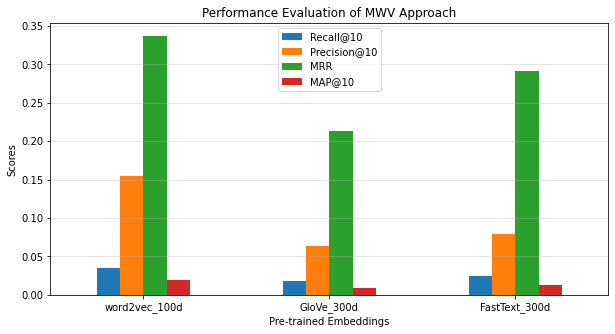

In [ ]:
df_performance.plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Performance Evaluation of MWV Approach')
plt.xlabel('Pre-trained Embeddings')
plt.ylabel('Scores')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

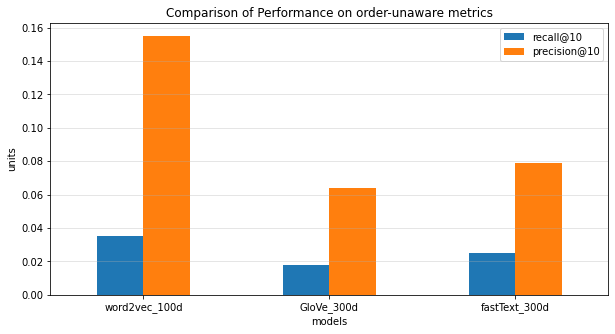

In [ ]:
df_performance[['model', 'recall@10', 'precision@10']].plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Comparison of Performance on order-unaware metrics')
plt.xlabel('models')
plt.ylabel('units')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

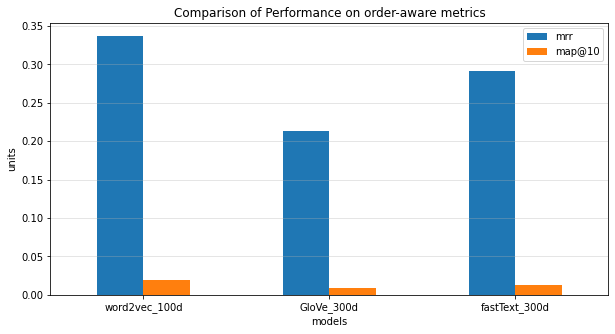

In [ ]:
df_performance[['model', 'mrr', 'map@10']].plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Comparison of Performance on order-aware metrics')
plt.xlabel('models')
plt.ylabel('units')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

#### Best Model: word2vec